<a href="https://colab.research.google.com/github/rafsanlab/etc/blob/main/U-net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Script 1

## Original codes

Based on [Amaarora Github](https://amaarora.github.io/2020/09/13/unet.html).

In [ ]:
import torch
import torchvision 
from torch import nn

In [ ]:
## BLOCK
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))

# check if it works
enc_block = Block(1, 64)
x         = torch.randn(1, 1, 572, 572)
enc_block(x).shape

torch.Size([1, 64, 568, 568])

In [ ]:
## ENCODER
class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs

# test if it works
encoder = Encoder()
# input image
x    = torch.randn(1, 3, 572, 572)
ftrs = encoder(x)
for ftr in ftrs: print(ftr.shape)

torch.Size([1, 64, 568, 568])
torch.Size([1, 128, 280, 280])
torch.Size([1, 256, 136, 136])
torch.Size([1, 512, 64, 64])
torch.Size([1, 1024, 28, 28])


In [ ]:
class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

# test of works
decoder = Decoder()
x = torch.randn(1, 1024, 28, 28)
decoder(x, ftrs[::-1][1:]).shape

torch.Size([1, 64, 388, 388])

In [ ]:
class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=False, out_sz=(572,572)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

# test if it works
unet = UNet()
x    = torch.randn(1, 3, 572, 572)
unet(x).shape

torch.Size([1, 1, 388, 388])

## Test on image

In [ ]:
from PIL import Image
from torchvision import transforms
import urllib.request

In [ ]:
# request image
IMG_LINK = 'https://cdn.britannica.com/84/73184-004-E5A450B5/Sunflower-field-Fargo-North-Dakota.jpg'
urllib.request.urlretrieve(IMG_LINK, 'flower.jpg')

# open the image
img = 'flower.jpg'
img = Image.open(img)

# convert to tensor
conv_tensor = transforms.ToTensor()
img = conv_tensor(img)

# expand dimensino to fit into the model
img = img.unsqueeze(dim=0)
img.shape

torch.Size([1, 3, 340, 550])

In [ ]:
# test on U-net
print(img.shape)

unet = UNet()
x    = img
img_seg = unet(x)
img_seg.shape

torch.Size([1, 3, 340, 550])


torch.Size([1, 1, 148, 356])

In [ ]:
# remove dimension 0
img_seg_s = img_seg.squeeze(0)
print(img_seg_s.shape)

# put channel to front
img_seg_s = img_seg_s.permute(1, 2, 0)
img_seg_s = img_seg_s.squeeze()
print(img_seg_s.shape)

torch.Size([1, 148, 356])
torch.Size([148, 356])


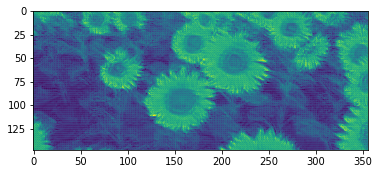

In [ ]:
img_seg_s = img_seg_s.detach().numpy()

# plot
from matplotlib import pyplot as plt
plt.imshow(img_seg_s, interpolation='nearest')
plt.show()

# Script 2

## Original codes

* this method from https://towardsdatascience.com/creating-and-training-a-u-net-model-with-pytorch-for-2d-3d-semantic-segmentation-model-building-6ab09d6a0862

* Download files method in colab: https://colab.research.google.com/github/jckantor/cbe61622/blob/master/docs/A.02-Downloading_Python_source_files_from_github.ipynb#scrollTo=70CslBHSOXMT

In [ ]:
url = f"https://raw.githubusercontent.com/ELEKTRONN/elektronn3/master/elektronn3/models/unet.py"
!wget --no-cache --backups=1 {url}

--2023-01-04 18:06:14--  https://raw.githubusercontent.com/ELEKTRONN/elektronn3/master/elektronn3/models/unet.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40556 (40K) [text/plain]
Failed to rename unet.py to unet.py.1: (2) No such file or directory
Saving to: ‘unet.py’

unet.py             100%[===================>]  39.61K  --.-KB/s    in 0.003s  

2023-01-04 18:06:14 (11.6 MB/s) - ‘unet.py’ saved [40556/40556]



In [ ]:
import torch
import torchvision 
from torch import nn

In [ ]:
from unet import UNet
model = UNet(in_channels=1,
             out_channels=2,
             n_blocks=4,
             #start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2)

# test the model
x = torch.randn(size=(1, 1, 512, 512), dtype=torch.float32)
with torch.no_grad():
    out = model(x)

print(f'Out: {out.shape}')

Out: torch.Size([1, 2, 512, 512])


## Test on image

In [ ]:
from PIL import Image
from torchvision import transforms
import urllib.request

In [ ]:
from PIL import Image
from torchvision import transforms
import urllib.request

# request image
IMG_LINK = 'https://cdn.britannica.com/84/73184-004-E5A450B5/Sunflower-field-Fargo-North-Dakota.jpg'
urllib.request.urlretrieve(IMG_LINK, 'flower.jpg')

# open the image
img = 'flower.jpg'
img = Image.open(img)

# convert to tensor
conv_tensor = transforms.ToTensor()
img = conv_tensor(img)

# expand dimensino to fit into the model
img = img.unsqueeze(dim=0)
img.shape

torch.Size([1, 3, 340, 550])

In [ ]:
model = UNet(in_channels=3,
             out_channels=3,
             n_blocks=4,
             #start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2)

# test on U-net
print(img.shape)
x    = img

with torch.no_grad():
    out = model(x)
print(f'Out: {out.shape}')

torch.Size([1, 3, 340, 550])
Out: torch.Size([1, 3, 340, 550])


In [ ]:
# remove dimension 0
out = out.squeeze(0)
print(out.shape)

# put channel to front
out = out.permute(1, 2, 0)
out = out.squeeze()
print(out.shape)

torch.Size([3, 340, 550])
torch.Size([340, 550, 3])


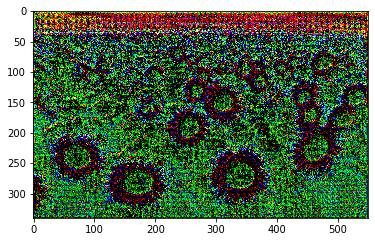

In [ ]:
out = out.detach().numpy()

# plot
from matplotlib import pyplot as plt
plt.imshow(out, interpolation='nearest')
plt.show()

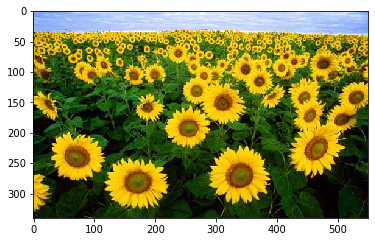

In [ ]:
img = 'flower.jpg'
img = Image.open(img)
plt.imshow(img, interpolation='nearest')
plt.show()


# Script 3

## Original codes

This script is based on the original U-Net paper as presented by [Abhishek](https://www.youtube.com/watch?v=u1loyDCoGbE):
* accept 1 channel -> output 1024 channel

In [ ]:
import torch
import torch.nn as nn

def double_conv(in_c, out_c):
  conv = nn.Sequential(
      nn.Conv2d(in_c, out_c, kernel_size=3),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_c, out_c, kernel_size=3),
      nn.ReLU(inplace=True)
  )
  return conv

def crop_tensor(tensor, target_tensor):
  # use to upsize current tensor to the target tensor
  target_size = target_tensor.size()[2] 
  tensor_size = tensor.size()[2]
  delta = tensor_size - target_size
  delta = delta // 2
  return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]

class UNet(nn.Module):
  def __init__(self):
      super(UNet, self).__init__()
      # declare variables for each in and out channels
      self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
      self.down_conv1 = double_conv(1, 64)
      self.down_conv2 = double_conv(64, 128)
      self.down_conv3 = double_conv(128, 256)
      self.down_conv4 = double_conv(256, 512)
      self.down_conv5 = double_conv(512, 1024)

      self.up_trans_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)    
      self.up_conv_1 = double_conv(1024, 512)
      self.up_trans_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
      self.up_conv_2 = double_conv(512, 256)
      self.up_trans_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)    
      self.up_conv_3 = double_conv(256, 128)
      self.up_trans_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)    
      self.up_conv_4 = double_conv(128, 64)

      self.out = nn.Conv2d(
          in_channels=64,
          out_channels=2,
          kernel_size=1,
      )

  def forward(self, img):
    # ecncoder section
    x1 = self.down_conv1(img) #->
    print(f'x1={x1.size()}')
    x2 = self.max_pool_2x2(x1) 
    x3 = self.down_conv2(x2) #->
    print(f'x3={x3.size()}')
    x4 = self.max_pool_2x2(x3) 
    x5 = self.down_conv3(x4) #->
    print(f'x5={x5.size()}')
    x6 = self.max_pool_2x2(x5)
    x7 = self.down_conv4(x6) #->
    print(f'x7={x7.size()}')
    x8 = self.max_pool_2x2(x7)
    x9 = self.down_conv5(x8)
    print(f'x9={x9.size()}')

    ## decoder section
    x = self.up_trans_1(x9)
    y = crop_tensor(x7, x)
    x = self.up_conv_1(torch.cat([x, y], 1))

    x = self.up_trans_2(x)
    y = crop_tensor(x5, x)
    x = self.up_conv_2(torch.cat([x, y], 1))

    x = self.up_trans_3(x)
    y = crop_tensor(x3, x)
    x = self.up_conv_3(torch.cat([x, y], 1))

    x = self.up_trans_4(x)
    y = crop_tensor(x1, x)
    x = self.up_conv_4(torch.cat([x, y], 1))

    x = self.out(x)
    print(x.size())
    return x

if __name__ == "__main__":
  img = torch.rand((1, 1, 572, 572))
  model = UNet()
  print(model(img))

x1=torch.Size([1, 64, 568, 568])
x3=torch.Size([1, 128, 280, 280])
x5=torch.Size([1, 256, 136, 136])
x7=torch.Size([1, 512, 64, 64])
x9=torch.Size([1, 1024, 28, 28])
torch.Size([1, 2, 388, 388])
tensor([[[[0.0400, 0.0488, 0.0461,  ..., 0.0396, 0.0412, 0.0390],
          [0.0461, 0.0396, 0.0402,  ..., 0.0394, 0.0479, 0.0500],
          [0.0423, 0.0416, 0.0478,  ..., 0.0506, 0.0483, 0.0411],
          ...,
          [0.0448, 0.0479, 0.0445,  ..., 0.0450, 0.0438, 0.0413],
          [0.0389, 0.0460, 0.0417,  ..., 0.0498, 0.0498, 0.0472],
          [0.0405, 0.0486, 0.0429,  ..., 0.0456, 0.0473, 0.0387]],

         [[0.0699, 0.0638, 0.0693,  ..., 0.0685, 0.0666, 0.0720],
          [0.0698, 0.0673, 0.0647,  ..., 0.0681, 0.0693, 0.0677],
          [0.0667, 0.0673, 0.0705,  ..., 0.0701, 0.0693, 0.0645],
          ...,
          [0.0644, 0.0644, 0.0593,  ..., 0.0699, 0.0676, 0.0675],
          [0.0734, 0.0761, 0.0657,  ..., 0.0671, 0.0680, 0.0674],
          [0.0681, 0.0738, 0.0629,  ..., 0.0643

In [ ]:
def crop_tensor(tensor, target_tensor):
  # use to upsize current tensor to the target tensor
  target_size = target_tensor.size()[2] 
  tensor_size = tensor.size()[2]
  delta = tensor_size - target_size
  delta = delta // 2
  print(delta)
  print(tensor_size-delta)
  return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]

im1 = torch.rand((1, 1, 512, 512))
im2 = torch.rand((1, 1, 1024, 1024))

im3 = crop_tensor(im2, im1)
im3.size()

256
768


torch.Size([1, 1, 512, 512])

## Test on image

change to accept 3 channels:

In [ ]:
import torch
import torch.nn as nn

def double_conv(in_c, out_c):
  conv = nn.Sequential(
      nn.Conv2d(in_c, out_c, kernel_size=3),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_c, out_c, kernel_size=3),
      nn.ReLU(inplace=True)
  )
  return conv

def crop_tensor(tensor, target_tensor):
  # use to upsize current tensor to the target tensor
  target_size = target_tensor.size()[2] 
  tensor_size = tensor.size()[2]
  delta = tensor_size - target_size
  delta = delta // 2
  return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]

class UNet(nn.Module):
  def __init__(self):
      super(UNet, self).__init__()
      # declare variables for each in and out channels
      self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
      self.down_conv1 = double_conv(3, 64) ##
      self.down_conv2 = double_conv(64, 128)
      self.down_conv3 = double_conv(128, 256)
      self.down_conv4 = double_conv(256, 512)
      self.down_conv5 = double_conv(512, 1024)

      self.up_trans_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)    
      self.up_conv_1 = double_conv(1024, 512)
      self.up_trans_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
      self.up_conv_2 = double_conv(512, 256)
      self.up_trans_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)    
      self.up_conv_3 = double_conv(256, 128)
      self.up_trans_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)    
      self.up_conv_4 = double_conv(128, 64)

      self.out = nn.Conv2d(
          in_channels=64,
          out_channels=1, ##
          kernel_size=1,
      )

  def forward(self, img):
    # ecncoder section
    x1 = self.down_conv1(img) #->
    x2 = self.max_pool_2x2(x1) 
    x3 = self.down_conv2(x2) #->
    x4 = self.max_pool_2x2(x3) 
    x5 = self.down_conv3(x4) #->
    x6 = self.max_pool_2x2(x5)
    x7 = self.down_conv4(x6) #->
    x8 = self.max_pool_2x2(x7)
    x9 = self.down_conv5(x8)
    print(x9.size())

    ## decoder section
    x = self.up_trans_1(x9)
    y = crop_tensor(x7, x)
    x = self.up_conv_1(torch.cat([x, y], 1))

    x = self.up_trans_2(x)
    y = crop_tensor(x5, x)
    x = self.up_conv_2(torch.cat([x, y], 1))

    x = self.up_trans_3(x)
    y = crop_tensor(x3, x)
    x = self.up_conv_3(torch.cat([x, y], 1))

    x = self.up_trans_4(x)
    y = crop_tensor(x1, x)
    x = self.up_conv_4(torch.cat([x, y], 1))

    x = self.out(x)
    print(x.size())
    return x

if __name__ == "__main__":
  img = torch.rand((1, 3, 572, 572)) ##
  model = UNet()
  print(model(img))

torch.Size([1, 1024, 28, 28])
torch.Size([1, 1, 388, 388])
tensor([[[[0.1180, 0.1175, 0.1162,  ..., 0.1175, 0.1130, 0.1181],
          [0.1181, 0.1169, 0.1178,  ..., 0.1179, 0.1147, 0.1177],
          [0.1142, 0.1160, 0.1146,  ..., 0.1181, 0.1186, 0.1178],
          ...,
          [0.1174, 0.1156, 0.1198,  ..., 0.1176, 0.1165, 0.1173],
          [0.1171, 0.1168, 0.1206,  ..., 0.1118, 0.1163, 0.1148],
          [0.1187, 0.1138, 0.1167,  ..., 0.1172, 0.1206, 0.1150]]]],
       grad_fn=<ConvolutionBackward0>)


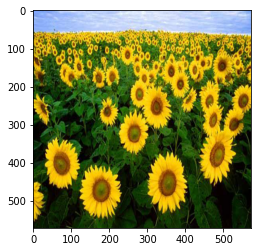

torch.Size([1, 3, 572, 572])


In [ ]:
from PIL import Image
from torchvision import transforms
import urllib.request
import matplotlib.pyplot as plt

# request image
IMG_LINK = 'https://cdn.britannica.com/84/73184-004-E5A450B5/Sunflower-field-Fargo-North-Dakota.jpg'
urllib.request.urlretrieve(IMG_LINK, 'flower.jpg')

# open the image
img = 'flower.jpg'
img = Image.open(img)
img = img.resize((572, 572))
plt.imshow(img)
plt.show()

# convert to tensor
conv_tensor = transforms.ToTensor()
img = conv_tensor(img)

# expand dimensino to fit into the model
img = img.unsqueeze(dim=0)
print(img.shape)

In [ ]:
if __name__ == "__main__":
  model = UNet()
  out = model(img)
  print(out)

torch.Size([1, 1024, 28, 28])
torch.Size([1, 1, 388, 388])
tensor([[[[0.0784, 0.0783, 0.0780,  ..., 0.0792, 0.0787, 0.0777],
          [0.0783, 0.0784, 0.0783,  ..., 0.0785, 0.0786, 0.0783],
          [0.0781, 0.0786, 0.0783,  ..., 0.0784, 0.0781, 0.0786],
          ...,
          [0.0801, 0.0799, 0.0804,  ..., 0.0794, 0.0800, 0.0795],
          [0.0792, 0.0794, 0.0796,  ..., 0.0790, 0.0791, 0.0791],
          [0.0801, 0.0798, 0.0804,  ..., 0.0794, 0.0800, 0.0794]]]],
       grad_fn=<ConvolutionBackward0>)


torch.Size([1, 388, 388])
torch.Size([388, 388])


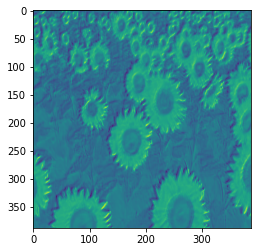

In [ ]:
# remove dimension 0
out = out.squeeze(0)
print(out.shape)

# put channel to front
out = out.permute(1, 2, 0)
out = out.squeeze()
print(out.shape)

out = out.detach().numpy()

# plot
from matplotlib import pyplot as plt
plt.imshow(out, cmap='viridis')
plt.show()

In [ ]:
import torch
import torch.nn as nn

def double_conv(in_c, out_c):
  conv = nn.Sequential(
      nn.Conv2d(in_c, out_c, kernel_size=3),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_c, out_c, kernel_size=3),
      nn.ReLU(inplace=True)
  )
  return conv

def crop_tensor(tensor, target_tensor):
  # use to upsize current tensor to the target tensor
  target_size = target_tensor.size()[2] 
  tensor_size = tensor.size()[2]
  delta = tensor_size - target_size
  delta = delta // 2
  return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]

class UNet(nn.Module):
  def __init__(self):
      super(UNet, self).__init__()
      # declare variables for each in and out channels
      self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
      self.down_conv1 = double_conv(3, 64) ##
      self.down_conv2 = double_conv(64, 128)
      self.down_conv3 = double_conv(128, 256)
      self.down_conv4 = double_conv(256, 512)
      self.down_conv5 = double_conv(512, 1024)

      self.up_trans_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)    
      self.up_conv_1 = double_conv(1024, 512)
      self.up_trans_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
      self.up_conv_2 = double_conv(512, 256)
      self.up_trans_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)    
      self.up_conv_3 = double_conv(256, 128)
      self.up_trans_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)    
      self.up_conv_4 = double_conv(128, 64)

      self.out = nn.Conv2d(
          in_channels=64,
          out_channels=1, ##
          kernel_size=1,
      )

  def forward(self, img):
    # ecncoder section
    x1 = self.down_conv1(img) #->
    x2 = self.max_pool_2x2(x1) 
    x3 = self.down_conv2(x2) #->
    x4 = self.max_pool_2x2(x3) 
    x5 = self.down_conv3(x4) #->
    x6 = self.max_pool_2x2(x5)
    x7 = self.down_conv4(x6) #->
    x8 = self.max_pool_2x2(x7)
    x9 = self.down_conv5(x8)
    print(x9.size())

    ## decoder section
    x = self.up_trans_1(x9)
    y = crop_tensor(x7, x)
    x = self.up_conv_1(torch.cat([x, y], 1))

    x = self.up_trans_2(x)
    y = crop_tensor(x5, x)
    x = self.up_conv_2(torch.cat([x, y], 1))

    x = self.up_trans_3(x)
    y = crop_tensor(x3, x)
    x = self.up_conv_3(torch.cat([x, y], 1))

    x = self.up_trans_4(x)
    y = crop_tensor(x1, x)
    x = self.up_conv_4(torch.cat([x, y], 1))

    x = self.out(x)
    print(x.size())
    return x

if __name__ == "__main__":
  img = torch.rand((1, 3, 572, 572)) ##
  model = UNet()
  print(model(img))

# Script 3.2

In [ ]:
import torch
import torch.nn as nn

def double_conv(in_c, out_c):
  conv = nn.Sequential(
      nn.Conv2d(in_c, out_c, kernel_size=3, padding='same'), ##
      nn.ReLU(inplace=True),
      nn.Conv2d(out_c, out_c, kernel_size=3, padding='same'), ##
      nn.ReLU(inplace=True)
  )
  return conv

def crop_tensor(tensor, target_tensor):
  # use to upsize current tensor to the target tensor
  target_size = target_tensor.size()[2] 
  tensor_size = tensor.size()[2]
  delta = tensor_size - target_size
  delta = delta // 2
  return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]

class UNet(nn.Module):
  def __init__(self):
      super(UNet, self).__init__()
      # declare variables for each in and out channels
      self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
      self.down_conv1 = double_conv(3, 64) ##
      self.down_conv2 = double_conv(64, 128)
      self.down_conv3 = double_conv(128, 256)
      self.down_conv4 = double_conv(256, 512)
      self.down_conv5 = double_conv(512, 1024)

      self.up_trans_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2, output_padding=0)    
      self.up_conv_1 = double_conv(1024, 512)
      self.up_trans_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2, output_padding=0)
      self.up_conv_2 = double_conv(512, 256)
      self.up_trans_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, output_padding=0)    
      self.up_conv_3 = double_conv(256, 128)
      self.up_trans_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2, output_padding=0)    
      self.up_conv_4 = double_conv(128, 64)

      self.out = nn.Conv2d(
          in_channels=64,
          out_channels=2, ##
          kernel_size=1,
      )

  def forward(self, img):
    # ecncoder section
    x1 = self.down_conv1(img) #->
    print(f'x1={x1.size()}')
    x2 = self.max_pool_2x2(x1) 
    x3 = self.down_conv2(x2) #->
    print(f'x3={x3.size()}')
    x4 = self.max_pool_2x2(x3) 
    x5 = self.down_conv3(x4) #->
    print(f'x5={x5.size()}')
    x6 = self.max_pool_2x2(x5)
    x7 = self.down_conv4(x6) #->
    print(f'x7={x7.size()}')
    x8 = self.max_pool_2x2(x7)
    x9 = self.down_conv5(x8)
    print(f'x9={x9.size()}')

    ## decoder section
    x = self.up_trans_1(x9)
    print(f'x={x.shape}')
    #y = crop_tensor(x7, x)
    y = x7
    x = self.up_conv_1(torch.cat([x, y], 1))

    x = self.up_trans_2(x)
    print(f'x={x.size()}')
    #y = crop_tensor(x5, x)
    y = x5
    x = self.up_conv_2(torch.cat([x, y], 1))

    x = self.up_trans_3(x)
    print(f'x={x.size()}')
    #y = crop_tensor(x3, x)
    y = x3
    x = self.up_conv_3(torch.cat([x, y], 1))

    x = self.up_trans_4(x)
    print(f'x={x.size()}')
    #y = crop_tensor(x1, x)
    y = x1
    x = self.up_conv_4(torch.cat([x, y], 1))

    x = self.out(x)
    print(f'x={x.size()}')
    return x

if __name__ == "__main__":
  img = torch.rand((1, 3, 512, 512)) ##
  model = UNet()
  model(img)

x1=torch.Size([1, 64, 512, 512])
x3=torch.Size([1, 128, 256, 256])
x5=torch.Size([1, 256, 128, 128])
x7=torch.Size([1, 512, 64, 64])
x9=torch.Size([1, 1024, 32, 32])
x=torch.Size([1, 512, 64, 64])
x=torch.Size([1, 256, 128, 128])
x=torch.Size([1, 128, 256, 256])
x=torch.Size([1, 64, 512, 512])
x=torch.Size([1, 2, 512, 512])


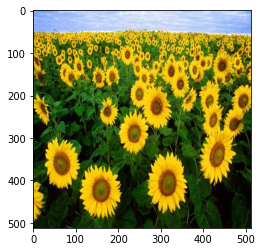

torch.Size([1, 3, 512, 512])
x1=torch.Size([1, 64, 512, 512])
x3=torch.Size([1, 128, 256, 256])
x5=torch.Size([1, 256, 128, 128])
x7=torch.Size([1, 512, 64, 64])
x9=torch.Size([1, 1024, 32, 32])
x=torch.Size([1, 512, 64, 64])
x=torch.Size([1, 256, 128, 128])
x=torch.Size([1, 128, 256, 256])
x=torch.Size([1, 64, 512, 512])
x=torch.Size([1, 2, 512, 512])
tensor([[[[ 0.0692,  0.0720,  0.0741,  ...,  0.0765,  0.0709,  0.0748],
          [ 0.0659,  0.0678,  0.0708,  ...,  0.0705,  0.0669,  0.0738],
          [ 0.0647,  0.0658,  0.0697,  ...,  0.0708,  0.0656,  0.0741],
          ...,
          [ 0.0663,  0.0702,  0.0694,  ...,  0.0687,  0.0691,  0.0712],
          [ 0.0668,  0.0685,  0.0671,  ...,  0.0669,  0.0681,  0.0701],
          [ 0.0669,  0.0686,  0.0674,  ...,  0.0680,  0.0681,  0.0686]],

         [[-0.0918, -0.0935, -0.0912,  ..., -0.0912, -0.0925, -0.0918],
          [-0.0893, -0.0910, -0.0896,  ..., -0.0924, -0.0945, -0.0959],
          [-0.0876, -0.0874, -0.0864,  ..., -0.0853,

In [ ]:
from PIL import Image
from torchvision import transforms
import urllib.request
import matplotlib.pyplot as plt

# request image
IMG_LINK = 'https://cdn.britannica.com/84/73184-004-E5A450B5/Sunflower-field-Fargo-North-Dakota.jpg'
urllib.request.urlretrieve(IMG_LINK, 'flower.jpg')

# open the image
img = 'flower.jpg'
img = Image.open(img)
img = img.resize((512, 512))
plt.imshow(img)
plt.show()

# convert to tensor
conv_tensor = transforms.ToTensor()
img = conv_tensor(img)

# expand dimensino to fit into the model
img = img.unsqueeze(dim=0)
print(img.shape)

if __name__ == "__main__":
  #img = torch.rand((1, 1, 572, 572))
  model = UNet()
  out = model(img)
  print(out)

# remove dimension 0
out = out.squeeze(0)
print(out.shape)

# put channel to front
out = out.permute(1, 2, 0)
out = out.squeeze()
print(out.shape)

out = out.detach().numpy()

# plot
# plot
from matplotlib import pyplot as plt
#plt.imshow(out, cmap='viridis')
#plt.show()

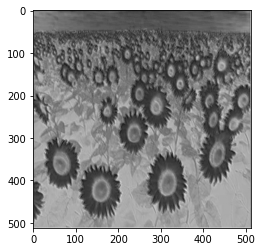

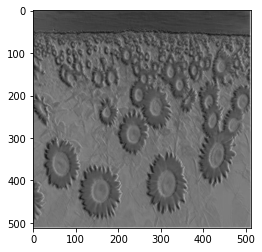

In [ ]:
out[:,:,0].shape

plt.imshow(out[:,:,0], cmap='binary')
plt.show()

plt.imshow(out[:,:,1], cmap='binary')
plt.show()

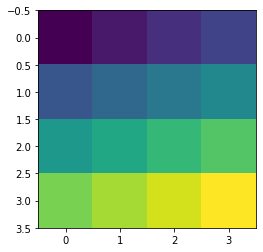

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt

H = np.array([[1, 2, 3, 4],
          [5, 6, 7, 8],
          [9, 10, 11, 12],
          [13, 14, 15, 16]])

plt.imshow(H, interpolation='none')
plt.show()

# Script 4

From [here](https://github.com/mtran5/UNet/blob/main/train.py).

## Original codes

In [ ]:
import torch
import numpy as np
import torch.nn as nn

class EncoderBlock(nn.Module):        
    # Consists of Conv -> ReLU -> MaxPool
    def __init__(self, in_chans, out_chans, layers=2, sampling_factor=2, padding="same"):
        super().__init__()
        self.encoder = nn.ModuleList()
        self.encoder.append(nn.Conv2d(in_chans, out_chans, 3, 1, padding=padding))
        self.encoder.append(nn.ReLU())
        for _ in range(layers-1): # add additional layers
            self.encoder.append(nn.Conv2d(out_chans, out_chans, 3, 1, padding=padding))
            self.encoder.append(nn.ReLU())
        self.mp = nn.MaxPool2d(sampling_factor) # kernel and stride
    def forward(self, x): # declare forward becauase of nn.ModuleList()
        for enc in self.encoder:
            x = enc(x)
        mp_out = self.mp(x)
        return mp_out, x

class DecoderBlock(nn.Module):
    # Consists of 2x2 transposed convolution -> Conv -> relu
    def __init__(self, in_chans, out_chans, layers=2, skip_connection=True, sampling_factor=2, padding="same"):
        super().__init__()
        skip_factor = 1 if skip_connection else 2
        self.decoder = nn.ModuleList()
        self.tconv = nn.ConvTranspose2d(in_chans, in_chans//2, sampling_factor, sampling_factor)

        self.decoder.append(nn.Conv2d(in_chans//skip_factor, out_chans, 3, 1, padding=padding))
        self.decoder.append(nn.ReLU())

        for _ in range(layers-1):
            self.decoder.append(nn.Conv2d(out_chans, out_chans, 3, 1, padding=padding))
            self.decoder.append(nn.ReLU())

        self.skip_connection = skip_connection
        self.padding = padding
    def forward(self, x, enc_features=None):
        x = self.tconv(x)
        if self.skip_connection:
            if self.padding != "same":
                # Crop the enc_features to the same size as input
                w = x.size(-1)
                c = (enc_features.size(-1) - w) // 2
                enc_features = enc_features[:,:,c:c+w,c:c+w]
            x = torch.cat((enc_features, x), dim=1)
        for dec in self.decoder:
            x = dec(x)
        return x

class UNet(nn.Module):
    def __init__(self, nclass=1, in_chans=1, depth=5, layers=2, sampling_factor=2, skip_connection=True, padding="same"):
        super().__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        out_chans = 64
        for _ in range(depth):
            self.encoder.append(EncoderBlock(in_chans, out_chans, layers, sampling_factor, padding))
            in_chans, out_chans = out_chans, out_chans*2

        out_chans = in_chans // 2
        for _ in range(depth-1):
            self.decoder.append(DecoderBlock(in_chans, out_chans, layers, skip_connection, sampling_factor, padding))
            in_chans, out_chans = out_chans, out_chans//2
        # Add a 1x1 convolution to produce final classes
        self.logits = nn.Conv2d(in_chans, nclass, 1, 1)

    def forward(self, x):
        encoded = []
        for enc in self.encoder:
            x, enc_output = enc(x)
            encoded.append(enc_output)
        x = encoded.pop()
        for dec in self.decoder:
            enc_output = encoded.pop()
            x = dec(x, enc_output)

        # Return the logits
        return self.logits(x)

if __name__ == "__main__":
  img = torch.rand((1, 1, 572, 572))
  model = UNet(in_chans=1, depth=3, layers=1, skip_connection=True)
  print(model(img))

tensor([[[[-0.0855, -0.0785, -0.0505,  ..., -0.0701, -0.0678, -0.0862],
          [-0.0806, -0.0726, -0.0929,  ..., -0.0574, -0.0954, -0.0493],
          [-0.0639, -0.0755, -0.0727,  ..., -0.0690, -0.0651, -0.0393],
          ...,
          [-0.0498, -0.0999, -0.0693,  ..., -0.1054, -0.0719, -0.0598],
          [-0.0698, -0.0718, -0.0776,  ..., -0.0582, -0.0757, -0.0532],
          [-0.0709, -0.0838, -0.0862,  ..., -0.0921, -0.0935, -0.0522]]]],
       grad_fn=<ConvolutionBackward0>)


## Test on image

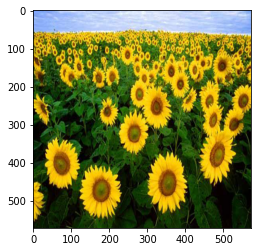

torch.Size([1, 3, 572, 572])


In [ ]:
from PIL import Image
from torchvision import transforms
import urllib.request
import matplotlib.pyplot as plt

# request image
IMG_LINK = 'https://cdn.britannica.com/84/73184-004-E5A450B5/Sunflower-field-Fargo-North-Dakota.jpg'
urllib.request.urlretrieve(IMG_LINK, 'flower.jpg')

# open the image
img = 'flower.jpg'
img = Image.open(img)
img = img.resize((572, 572))
plt.imshow(img)
plt.show()

# convert to tensor
conv_tensor = transforms.ToTensor()
img = conv_tensor(img)

# expand dimensino to fit into the model
img = img.unsqueeze(dim=0)
print(img.shape)

In [ ]:
if __name__ == "__main__":
  #img = torch.rand((1, 1, 572, 572))
  model = UNet(in_chans=3, depth=3, layers=1, skip_connection=True)
  out = model(img)
  print(out)

tensor([[[[-0.0122, -0.0057, -0.0025,  ..., -0.0028, -0.0100, -0.0112],
          [-0.0205,  0.0219,  0.0457,  ...,  0.0455,  0.0332,  0.0246],
          [-0.0288,  0.0071,  0.0251,  ...,  0.0223,  0.0150,  0.0305],
          ...,
          [-0.0139,  0.0010,  0.0014,  ...,  0.0014,  0.0011, -0.0147],
          [-0.0143,  0.0006,  0.0015,  ...,  0.0012,  0.0003, -0.0139],
          [-0.0167, -0.0116, -0.0107,  ..., -0.0113, -0.0116, -0.0124]]]],
       grad_fn=<ConvolutionBackward0>)


torch.Size([1, 572, 572])
torch.Size([572, 572])


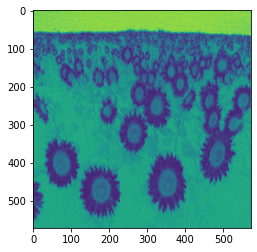

In [ ]:
# remove dimension 0
out = out.squeeze(0)
print(out.shape)

# put channel to front
out = out.permute(1, 2, 0)
out = out.squeeze()
print(out.shape)

out = out.detach().numpy()

# plot
from matplotlib import pyplot as plt
plt.imshow(out, cmap='viridis')
plt.show()

# Script 5

In [ ]:
import os
if not os.path.exists('dataset1'):
    !wget -q https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
    !unzip -q dataset1.zip
    !rm dataset1.zip
    !pip install -q torch_snippets pytorch_model_summary

from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torchvision.models import vgg16_bn
from tqdm import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 KB 115.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 KB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.9/201.9 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 96.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.0/174.0 KB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
class config:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    LEARNING_RATE = 1e-3
    N_EPOCHS = 2 #20


In [ ]:
def get_transforms():
  return transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                 [0.485, 0.456, 0.406], 
                                 [0.229, 0.224, 0.225]
                                 )
                             ])


In [ ]:
split = 'test'
s = stems(f'dataset1/images_prepped_{split}')
type(s)
len(s)

101

In [ ]:
class SegmentationData(Dataset):
    def __init__(self, split):
        # get each images in the folder
        self.items = stems(f'dataset1/images_prepped_{split}')
        self.split = split

    def __len__(self):
        return len(self.items)

    def __getitem__(self, ix):
        image = read(f'dataset1/images_prepped_{self.split}/{self.items[ix]}.png', 1)
        image = cv2.resize(image, (224,224))
        mask = read(f'dataset1/annotations_prepped_{self.split}/{self.items[ix]}.png')
        mask = cv2.resize(mask, (224,224))
        return image, mask

    def choose(self): return self[randint(len(self))]
    
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([get_transforms()(im.copy()/255.)[None] for im in ims]).float().to(config.DEVICE)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(config.DEVICE)
        return ims, ce_masks

In [ ]:
def get_dataloaders():
  trn_ds = SegmentationData('train')
  val_ds = SegmentationData('test')
  trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True, collate_fn=trn_ds.collate_fn)
  val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)
  return trn_dl, val_dl

trn_dl, val_dl = get_dataloaders()

In [ ]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [ ]:
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

In [ ]:
class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()

        self.encoder = vgg16_bn(pretrained=pretrained).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
        
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)
        return x

In [ ]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

In [ ]:
class engine():
  def train_batch(model, data, optimizer, criterion):
      model.train()

      ims, ce_masks = data
      _masks = model(ims)
      optimizer.zero_grad()

      loss, acc = criterion(_masks, ce_masks)
      loss.backward()
      optimizer.step()

      return loss.item(), acc.item()


  @torch.no_grad()
  def validate_batch(model, data, criterion):
      model.eval()

      ims, masks = data
      _masks = model(ims)

      loss, acc = criterion(_masks, masks)

      return loss.item(), acc.item()

In [ ]:
def make_model():
  model = UNet().to(config.DEVICE)
  criterion = UnetLoss
  optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
  return model, criterion, optimizer

model, criterion, optimizer = make_model()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
def run():
  for epoch in range(config.N_EPOCHS):
      print("####################")
      print(f"       Epoch: {epoch}   ")
      print("####################")

      for bx, data in tqdm(enumerate(trn_dl), total = len(trn_dl)):
          train_loss, train_acc = engine.train_batch(model, data, optimizer, criterion)

      for bx, data in tqdm(enumerate(val_dl), total = len(val_dl)):
          val_loss, val_acc = engine.validate_batch(model, data, criterion)
      print()


In [ ]:
run()

####################

Epoch: 0

####################

100%|██████████| 101/101 [00:02<00:00, 46.36it/s]


####################

Epoch: 1

####################

100%|██████████| 101/101 [00:02<00:00, 46.65it/s]


# Script 5.1

In [1]:
import os
'''
if not os.path.exists('dataset1'):
    !wget -q https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
    !unzip -q dataset1.zip
    !rm dataset1.zip
    !pip install -q torch_snippets pytorch_model_summary
'''
from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torchvision.models import vgg16_bn
from tqdm import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 25.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 KB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.9/201.9 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 112.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.0/174.0 KB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 114.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [100]:
class config:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    LEARNING_RATE = 1e-3
    N_EPOCHS = 1 #20

In [101]:
def get_transforms():
  return transforms.Compose([
                             transforms.ToTensor(),
                             ])

In [112]:
# copy data
path = '/content/drive/MyDrive/wsi_crc/data/ml'
!cp -r '/content/drive/MyDrive/wsi_crc/data/ml' .

In [131]:
class SegmentationData(Dataset):
    def __init__(self, split):
        # get each images in the folder
        self.items = stems(f'ml/ftir_{split}')
        self.split = split

    def __len__(self):
        return len(self.items)

    def __getitem__(self, ix):
        #image = read(f'dataset1/ftir_{self.split}/{self.items[ix]}.npy', 1)
        #image = cv2.resize(image, (224,224))
        image = np.load(f'ml/ftir_{self.split}/{self.items[ix]}.npy')
        #mask = read(f'dataset1/hne_{self.split}/{self.items[ix]}.npy')
        #mask = cv2.resize(mask, (224,224))
        mask = np.load(f'ml/hne_{self.split}/{self.items[ix]}.npy')
        return image, mask

    def choose(self): return self[randint(len(self))]
    
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([get_transforms()(im.copy()/255.)[None] for im in ims]).float().to(config.DEVICE)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(config.DEVICE)
        return ims, ce_masks

In [135]:
def get_dataloaders():
  trn_ds = SegmentationData('train')
  val_ds = SegmentationData('test')
  #trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True, collate_fn=trn_ds.collate_fn)
  trn_dl = DataLoader(trn_ds, batch_size=1, shuffle=True)#, collate_fn=trn_ds.collate_fn)
  val_dl = DataLoader(val_ds, batch_size=1, shuffle=True)#, collate_fn=val_ds.collate_fn)
  return trn_dl, val_dl

trn_dl, val_dl = get_dataloaders()

# check the data
for i in val_dl: print(i)
for i in trn_dl: print(i)

[
    tensor[1, 493, 256, 256] f64 n=32309248 x∈[0., 8.117] μ=0.093 σ=0.125,
    tensor[1, 3, 256, 256] u8 n=196608 x∈[11, 255] μ=199.929 σ=49.939
]

[
    tensor[1, 493, 256, 256] f64 n=32309248 x∈[0., 8.653] μ=0.118 σ=0.184,
    tensor[1, 3, 256, 256] u8 n=196608 x∈[29, 255] μ=205.345 σ=44.004
]

In [122]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [123]:
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

In [139]:
def double_conv(in_channels, out_channels):
  conv = nn.Sequential(
      nn.BatchNorm2d(in_channels),
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'), ##
      nn.ReLU(inplace=True),
      nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'), ##
      nn.ReLU(inplace=True)
  )

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # declare variables for each in and out channels
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv1 = double_conv(493, 512) ##
        self.down_conv2 = double_conv(512, 1024)
        self.down_conv3 = double_conv(1024, 2048)
        self.down_conv4 = double_conv(2048, 4096)
        self.down_conv5 = double_conv(4096, 8192)

        self.up_trans_1 = nn.ConvTranspose2d(in_channels=8192, out_channels=4096, kernel_size=2, stride=2, output_padding=0)    
        self.up_conv_1 = double_conv(8192, 4096)
        self.up_trans_2 = nn.ConvTranspose2d(in_channels=4096, out_channels=2048, kernel_size=2, stride=2, output_padding=0)
        self.up_conv_2 = double_conv(4096, 2048)
        self.up_trans_3 = nn.ConvTranspose2d(in_channels=2048, out_channels=1024, kernel_size=2, stride=2, output_padding=0)    
        self.up_conv_3 = double_conv(2048, 1024)
        self.up_trans_4 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2, output_padding=0)    
        self.up_conv_4 = double_conv(512, 256)

        self.out = nn.Conv2d(in_channels=256, out_channels=3, kernel_size=1)

    def forward(self, x):
      # ecncoder section
      x1 = self.down_conv1(x)
      x2 = self.max_pool_2x2(x1) 
      x3 = self.down_conv2(x2)
      x4 = self.max_pool_2x2(x3) 
      x5 = self.down_conv3(x4)
      x6 = self.max_pool_2x2(x5)
      x7 = self.down_conv4(x6)
      x8 = self.max_pool_2x2(x7)
      x9 = self.down_conv5(x8)

      ## decoder section

      x = self.up_trans_1(x9)
      y = x7
      x = self.up_conv_1(torch.cat([x, y], 1))

      x = self.up_trans_2(x)
      y = x5
      x = self.up_conv_2(torch.cat([x, y], 1))

      x = self.up_trans_3(x)
      y = x3
      x = self.up_conv_3(torch.cat([x, y], 1))

      x = self.up_trans_4(x)
      y = x1
      x = self.up_conv_4(torch.cat([x, y], 1))

      x = self.out(x)
      print(f'x={x.size()}')

      return x

In [140]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

In [141]:
class engine():
  def train_batch(model, data, optimizer, criterion):
      model.train()

      ims, ce_masks = data
      _masks = model(ims)
      optimizer.zero_grad()

      loss, acc = criterion(_masks, ce_masks)
      loss.backward()
      optimizer.step()

      return loss.item(), acc.item()


  @torch.no_grad()
  def validate_batch(model, data, criterion):
      model.eval()

      ims, masks = data
      _masks = model(ims)

      loss, acc = criterion(_masks, masks)

      return loss.item(), acc.item()

In [142]:
def make_model():
  model = UNet().to(config.DEVICE)
  criterion = UnetLoss
  optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
  return model, criterion, optimizer

model, criterion, optimizer = make_model()

In [144]:
def run():
  for epoch in range(config.N_EPOCHS):
      print("####################")
      print(f"       Epoch: {epoch}   ")
      print("####################")

      for bx, data in tqdm(enumerate(trn_dl), total = len(trn_dl)):
          train_loss, train_acc = engine.train_batch(model, data, optimizer, criterion)

      for bx, data in tqdm(enumerate(val_dl), total = len(val_dl)):
          val_loss, val_acc = engine.validate_batch(model, data, criterion)
      print()


In [155]:
run()

####################

Epoch: 0

####################

  0%|          | 0/1 [00:00<?, ?it/s]


RuntimeError: ignored

# Script 6

In [146]:
from torch import nn
import torch


@torch.jit.script
def autocrop(encoder_layer: torch.Tensor, decoder_layer: torch.Tensor):
    """
    Center-crops the encoder_layer to the size of the decoder_layer,
    so that merging (concatenation) between levels/blocks is possible.
    This is only necessary for input sizes != 2**n for 'same' padding and always required for 'valid' padding.
    """
    if encoder_layer.shape[2:] != decoder_layer.shape[2:]:
        ds = encoder_layer.shape[2:]
        es = decoder_layer.shape[2:]
        assert ds[0] >= es[0]
        assert ds[1] >= es[1]
        if encoder_layer.dim() == 4:  # 2D
            encoder_layer = encoder_layer[
                            :,
                            :,
                            ((ds[0] - es[0]) // 2):((ds[0] + es[0]) // 2),
                            ((ds[1] - es[1]) // 2):((ds[1] + es[1]) // 2)
                            ]
        elif encoder_layer.dim() == 5:  # 3D
            assert ds[2] >= es[2]
            encoder_layer = encoder_layer[
                            :,
                            :,
                            ((ds[0] - es[0]) // 2):((ds[0] + es[0]) // 2),
                            ((ds[1] - es[1]) // 2):((ds[1] + es[1]) // 2),
                            ((ds[2] - es[2]) // 2):((ds[2] + es[2]) // 2),
                            ]
    return encoder_layer, decoder_layer


def conv_layer(dim: int):
    if dim == 3:
        return nn.Conv3d
    elif dim == 2:
        return nn.Conv2d


def get_conv_layer(in_channels: int,
                   out_channels: int,
                   kernel_size: int = 3,
                   stride: int = 1,
                   padding: int = 1,
                   bias: bool = True,
                   dim: int = 2):
    return conv_layer(dim)(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,
                           bias=bias)


def conv_transpose_layer(dim: int):
    if dim == 3:
        return nn.ConvTranspose3d
    elif dim == 2:
        return nn.ConvTranspose2d


def get_up_layer(in_channels: int,
                 out_channels: int,
                 kernel_size: int = 2,
                 stride: int = 2,
                 dim: int = 3,
                 up_mode: str = 'transposed',
                 ):
    if up_mode == 'transposed':
        return conv_transpose_layer(dim)(in_channels, out_channels, kernel_size=kernel_size, stride=stride)
    else:
        return nn.Upsample(scale_factor=2.0, mode=up_mode)


def maxpool_layer(dim: int):
    if dim == 3:
        return nn.MaxPool3d
    elif dim == 2:
        return nn.MaxPool2d


def get_maxpool_layer(kernel_size: int = 2,
                      stride: int = 2,
                      padding: int = 0,
                      dim: int = 2):
    return maxpool_layer(dim=dim)(kernel_size=kernel_size, stride=stride, padding=padding)


def get_activation(activation: str):
    if activation == 'relu':
        return nn.ReLU()
    elif activation == 'leaky':
        return nn.LeakyReLU(negative_slope=0.1)
    elif activation == 'elu':
        return nn.ELU()


def get_normalization(normalization: str,
                      num_channels: int,
                      dim: int):
    if normalization == 'batch':
        if dim == 3:
            return nn.BatchNorm3d(num_channels)
        elif dim == 2:
            return nn.BatchNorm2d(num_channels)
    elif normalization == 'instance':
        if dim == 3:
            return nn.InstanceNorm3d(num_channels)
        elif dim == 2:
            return nn.InstanceNorm2d(num_channels)
    elif 'group' in normalization:
        num_groups = int(normalization.partition('group')[-1])  # get the group size from string
        return nn.GroupNorm(num_groups=num_groups, num_channels=num_channels)


class Concatenate(nn.Module):
    def __init__(self):
        super(Concatenate, self).__init__()

    def forward(self, layer_1, layer_2):
        x = torch.cat((layer_1, layer_2), 1)

        return x


class DownBlock(nn.Module):
    """
    A helper Module that performs 2 Convolutions and 1 MaxPool.
    An activation follows each convolution.
    A normalization layer follows each convolution.
    """

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 pooling: bool = True,
                 activation: str = 'relu',
                 normalization: str = None,
                 dim: str = 2,
                 conv_mode: str = 'same'):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling
        self.normalization = normalization
        if conv_mode == 'same':
            self.padding = 1
        elif conv_mode == 'valid':
            self.padding = 0
        self.dim = dim
        self.activation = activation

        # conv layers
        self.conv1 = get_conv_layer(self.in_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)
        self.conv2 = get_conv_layer(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)

        # pooling layer
        if self.pooling:
            self.pool = get_maxpool_layer(kernel_size=2, stride=2, padding=0, dim=self.dim)

        # activation layers
        self.act1 = get_activation(self.activation)
        self.act2 = get_activation(self.activation)

        # normalization layers
        if self.normalization:
            self.norm1 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm2 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)

    def forward(self, x):
        y = self.conv1(x)  # convolution 1
        y = self.act1(y)  # activation 1
        if self.normalization:
            y = self.norm1(y)  # normalization 1
        y = self.conv2(y)  # convolution 2
        y = self.act2(y)  # activation 2
        if self.normalization:
            y = self.norm2(y)  # normalization 2

        before_pooling = y  # save the outputs before the pooling operation
        if self.pooling:
            y = self.pool(y)  # pooling
        return y, before_pooling


class UpBlock(nn.Module):
    """
    A helper Module that performs 2 Convolutions and 1 UpConvolution/Upsample.
    An activation follows each convolution.
    A normalization layer follows each convolution.
    """

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 activation: str = 'relu',
                 normalization: str = None,
                 dim: int = 3,
                 conv_mode: str = 'same',
                 up_mode: str = 'transposed'
                 ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalization = normalization
        if conv_mode == 'same':
            self.padding = 1
        elif conv_mode == 'valid':
            self.padding = 0
        self.dim = dim
        self.activation = activation
        self.up_mode = up_mode

        # upconvolution/upsample layer
        self.up = get_up_layer(self.in_channels, self.out_channels, kernel_size=2, stride=2, dim=self.dim,
                               up_mode=self.up_mode)

        # conv layers
        self.conv0 = get_conv_layer(self.in_channels, self.out_channels, kernel_size=1, stride=1, padding=0,
                                    bias=True, dim=self.dim)
        self.conv1 = get_conv_layer(2 * self.out_channels, self.out_channels, kernel_size=3, stride=1,
                                    padding=self.padding,
                                    bias=True, dim=self.dim)
        self.conv2 = get_conv_layer(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)

        # activation layers
        self.act0 = get_activation(self.activation)
        self.act1 = get_activation(self.activation)
        self.act2 = get_activation(self.activation)

        # normalization layers
        if self.normalization:
            self.norm0 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm1 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm2 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)

        # concatenate layer
        self.concat = Concatenate()

    def forward(self, encoder_layer, decoder_layer):
        """ Forward pass
        Arguments:
            encoder_layer: Tensor from the encoder pathway
            decoder_layer: Tensor from the decoder pathway (to be up'd)
        """
        up_layer = self.up(decoder_layer)  # up-convolution/up-sampling
        cropped_encoder_layer, dec_layer = autocrop(encoder_layer, up_layer)  # cropping

        if self.up_mode != 'transposed':
            # We need to reduce the channel dimension with a conv layer
            up_layer = self.conv0(up_layer)  # convolution 0
        up_layer = self.act0(up_layer)  # activation 0
        if self.normalization:
            up_layer = self.norm0(up_layer)  # normalization 0

        merged_layer = self.concat(up_layer, cropped_encoder_layer)  # concatenation
        y = self.conv1(merged_layer)  # convolution 1
        y = self.act1(y)  # activation 1
        if self.normalization:
            y = self.norm1(y)  # normalization 1
        y = self.conv2(y)  # convolution 2
        y = self.act2(y)  # acivation 2
        if self.normalization:
            y = self.norm2(y)  # normalization 2
        return y


class UNet(nn.Module):
    def __init__(self,
                 in_channels: int = 1,
                 out_channels: int = 2,
                 n_blocks: int = 4,
                 start_filters: int = 32,
                 activation: str = 'relu',
                 normalization: str = 'batch',
                 conv_mode: str = 'same',
                 dim: int = 2,
                 up_mode: str = 'transposed'
                 ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_blocks = n_blocks
        self.start_filters = start_filters
        self.activation = activation
        self.normalization = normalization
        self.conv_mode = conv_mode
        self.dim = dim
        self.up_mode = up_mode

        self.down_blocks = []
        self.up_blocks = []

        # create encoder path
        for i in range(self.n_blocks):
            num_filters_in = self.in_channels if i == 0 else num_filters_out
            num_filters_out = self.start_filters * (2 ** i)
            pooling = True if i < self.n_blocks - 1 else False

            down_block = DownBlock(in_channels=num_filters_in,
                                   out_channels=num_filters_out,
                                   pooling=pooling,
                                   activation=self.activation,
                                   normalization=self.normalization,
                                   conv_mode=self.conv_mode,
                                   dim=self.dim)

            self.down_blocks.append(down_block)

        # create decoder path (requires only n_blocks-1 blocks)
        for i in range(n_blocks - 1):
            num_filters_in = num_filters_out
            num_filters_out = num_filters_in // 2

            up_block = UpBlock(in_channels=num_filters_in,
                               out_channels=num_filters_out,
                               activation=self.activation,
                               normalization=self.normalization,
                               conv_mode=self.conv_mode,
                               dim=self.dim,
                               up_mode=self.up_mode)

            self.up_blocks.append(up_block)

        # final convolution
        self.conv_final = get_conv_layer(num_filters_out, self.out_channels, kernel_size=1, stride=1, padding=0,
                                         bias=True, dim=self.dim)

        # add the list of modules to current module
        self.down_blocks = nn.ModuleList(self.down_blocks)
        self.up_blocks = nn.ModuleList(self.up_blocks)

        # initialize the weights
        self.initialize_parameters()

    @staticmethod
    def weight_init(module, method, **kwargs):
        if isinstance(module, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            method(module.weight, **kwargs)  # weights

    @staticmethod
    def bias_init(module, method, **kwargs):
        if isinstance(module, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            method(module.bias, **kwargs)  # bias

    def initialize_parameters(self,
                              method_weights=nn.init.xavier_uniform_,
                              method_bias=nn.init.zeros_,
                              kwargs_weights={},
                              kwargs_bias={}
                              ):
        for module in self.modules():
            self.weight_init(module, method_weights, **kwargs_weights)  # initialize weights
            self.bias_init(module, method_bias, **kwargs_bias)  # initialize bias

    def forward(self, x: torch.tensor):
        encoder_output = []

        # Encoder pathway
        for module in self.down_blocks:
            x, before_pooling = module(x)
            encoder_output.append(before_pooling)

        # Decoder pathway
        for i, module in enumerate(self.up_blocks):
            before_pool = encoder_output[-(i + 2)]
            x = module(before_pool, x)

        x = self.conv_final(x)

        return x

    def __repr__(self):
        attributes = {attr_key: self.__dict__[attr_key] for attr_key in self.__dict__.keys() if '_' not in attr_key[0] and 'training' not in attr_key}
        d = {self.__class__.__name__: attributes}
        return f'{d}'

In [148]:
#from unet import UNet
model = UNet(in_channels=1,
             out_channels=2,
             n_blocks=4,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2)

x = torch.randn(size=(1, 1, 512, 512), dtype=torch.float32)
with torch.no_grad():
    out = model(x)

print(f'Out: {out.shape}')

Out: torch.Size([1, 2, 512, 512])

In [149]:
from torchsummary import summary
summary = summary(model, (1, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 512]             320
              ReLU-2         [-1, 32, 512, 512]               0
       BatchNorm2d-3         [-1, 32, 512, 512]              64
            Conv2d-4         [-1, 32, 512, 512]           9,248
              ReLU-5         [-1, 32, 512, 512]               0
       BatchNorm2d-6         [-1, 32, 512, 512]              64
         MaxPool2d-7         [-1, 32, 256, 256]               0
         DownBlock-8  [[-1, 32, 256, 256], [-1, 32, 512, 512]]               0
            Conv2d-9         [-1, 64, 256, 256]          18,496
             ReLU-10         [-1, 64, 256, 256]               0
      BatchNorm2d-11         [-1, 64, 256, 256]             128
           Conv2d-12         [-1, 64, 256, 256]          36,928
             ReLU-13         [-1, 64, 256, 256]               0
      BatchNorm2d-14    

In [150]:
shape = 1920

def compute_max_depth(shape, max_depth=10, print_out=True):
    shapes = []
    shapes.append(shape)
    for level in range(1, max_depth):
        if shape % 2 ** level == 0 and shape / 2 ** level > 1:
            shapes.append(shape / 2 ** level)
            if print_out:
                print(f'Level {level}: {shape / 2 ** level}')
        else:
            if print_out:
                print(f'Max-level: {level - 1}')
            break

    return shapes

out = compute_max_depth(shape, print_out=True, max_depth=10)


Level 1: 960.0

Level 2: 480.0

Level 3: 240.0

Level 4: 120.0

Level 5: 60.0

Level 6: 30.0

Level 7: 15.0

Max-level: 7

In [152]:
low = 10
high = 512
depth = 8

def compute_possible_shapes(low, high, depth):
    possible_shapes = {}
    for shape in range(low, high + 1):
        shapes = compute_max_depth(shape,
                                   max_depth=depth,
                                   print_out=False)
        if len(shapes) == depth:
            possible_shapes[shape] = shapes

    return possible_shapes
possible_shapes = compute_possible_shapes(low, high, depth)

In [153]:
import numpy as np
import torch


class Trainer:
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset = None,
                 lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook

        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []

    def run_trainer(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        progressbar = trange(self.epochs, desc='Progress')
        for i in progressbar:
            """Epoch counter"""
            self.epoch += 1  # epoch counter

            """Training block"""
            self._train()

            """Validation block"""
            if self.validation_DataLoader is not None:
                self._validate()

            """Learning rate scheduler block"""
            if self.lr_scheduler is not None:
                if self.validation_DataLoader is not None and self.lr_scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                    self.lr_scheduler.batch(self.validation_loss[i])  # learning rate scheduler step with validation loss
                else:
                    self.lr_scheduler.batch()  # learning rate scheduler step
        return self.training_loss, self.validation_loss, self.learning_rate

    def _train(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.train()  # train mode
        train_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', total=len(self.training_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
            self.optimizer.zero_grad()  # zerograd the parameters
            out = self.model(input)  # one forward pass
            loss = self.criterion(out, target)  # calculate loss
            loss_value = loss.item()
            train_losses.append(loss_value)
            loss.backward()  # one backward pass
            self.optimizer.step()  # update the parameters

            batch_iter.set_description(f'Training: (loss {loss_value:.4f})')  # update progressbar

        self.training_loss.append(np.mean(train_losses))
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])

        batch_iter.close()

    def _validate(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.eval()  # evaluation mode
        valid_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'Validation', total=len(self.validation_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

            with torch.no_grad():
                out = self.model(input)
                loss = self.criterion(out, target)
                loss_value = loss.item()
                valid_losses.append(loss_value)

                batch_iter.set_description(f'Validation: (loss {loss_value:.4f})')

        self.validation_loss.append(np.mean(valid_losses))

        batch_iter.close()

In [154]:
# Imports
import pathlib
import torch

import albumentations
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from skimage.transform import resize
from customdatasets import SegmentationDataSet1
from transformations import ComposeDouble, AlbuSeg2d, FunctionWrapperDouble, normalize_01, create_dense_target
from unet import UNet
from trainer import Trainer


# root directory
root = pathlib.Path.cwd() / 'Carvana'


def get_filenames_of_path(path: pathlib.Path, ext: str = '*'):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [file for file in path.glob(ext) if file.is_file()]
    return filenames


# input and target files
inputs = get_filenames_of_path(root / 'Input')
targets = get_filenames_of_path(root / 'Target')

# training transformations and augmentations
transforms_training = ComposeDouble([
    FunctionWrapperDouble(resize,
                          input=True,
                          target=False,
                          output_shape=(128, 128, 3)),
    FunctionWrapperDouble(resize,
                          input=False,
                          target=True,
                          output_shape=(128, 128),
                          order=0,
                          anti_aliasing=False,
                          preserve_range=True),
    AlbuSeg2d(albumentations.HorizontalFlip(p=0.5)),
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)
])

# validation transformations
transforms_validation = ComposeDouble([
    FunctionWrapperDouble(resize,
                          input=True,
                          target=False,
                          output_shape=(128, 128, 3)),
    FunctionWrapperDouble(resize,
                          input=False,
                          target=True,
                          output_shape=(128, 128),
                          order=0,
                          anti_aliasing=False,
                          preserve_range=True),
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)
])

# random seed
random_seed = 42

# split dataset into training set and validation set
train_size = 0.8  # 80:20 split

inputs_train, inputs_valid = train_test_split(
    inputs,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

targets_train, targets_valid = train_test_split(
    targets,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

# inputs_train, inputs_valid = inputs[:80], inputs[80:]
# targets_train, targets_valid = targets[:80], targets[:80]

# dataset training
dataset_train = SegmentationDataSet1(inputs=inputs_train,
                                    targets=targets_train,
                                    transform=transforms_training)

# dataset validation
dataset_valid = SegmentationDataSet1(inputs=inputs_valid,
                                    targets=targets_valid,
                                    transform=transforms_validation)

# dataloader training
dataloader_training = DataLoader(dataset=dataset_train,
                                 batch_size=2,
                                 shuffle=True)

# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid,
                                   batch_size=2,
                                   shuffle=True)

ModuleNotFoundError: ignored

# Script 7

In [156]:
# import the necessary packages
import torch
import os

# base path of the dataset
DATASET_PATH = os.path.join("dataset", "train")

# define the path to the images and masks dataset
IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "images")
MASK_DATASET_PATH = os.path.join(DATASET_PATH, "masks")

# define the test split
TEST_SPLIT = 0.15

# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

In [158]:
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3

# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 40
BATCH_SIZE = 64

# define the input image dimensions
INPUT_IMAGE_WIDTH = 128
INPUT_IMAGE_HEIGHT = 128

# define threshold to filter weak predictions
THRESHOLD = 0.5

# define the path to the base output directory
BASE_OUTPUT = "output"

# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_tgs_salt.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [159]:
# import the necessary packages
from torch.utils.data import Dataset
import cv2

class SegmentationDataset(Dataset):

	def __init__(self, imagePaths, maskPaths, transforms):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
  
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		mask = cv2.imread(self.maskPaths[idx], 0)
		# check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			image = self.transforms(image)
			mask = self.transforms(mask)
		# return a tuple of the image and its mask
    
		return (image, mask)

In [161]:
# import the necessary packages
#from . import config
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch

In [162]:
class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)
  
	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))

In [163]:
class Encoder(Module):
  
	def __init__(self, channels=(3, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
  
	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		# return the list containing the intermediate outputs
		return blockOutputs

In [164]:
class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures

In [166]:
class UNet(Module):
	def __init__(self, encChannels=(3, 16, 32, 64),
		 decChannels=(64, 32, 16),
		 nbClasses=1, retainDim=True,
		 #outSize=(config.INPUT_IMAGE_HEIGHT,  config.INPUT_IMAGE_WIDTH)):
     outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
		super().__init__()
		# initialize the encoder and decoder
		self.encoder = Encoder(encChannels)
		self.decoder = Decoder(decChannels)
		# initialize the regression head and store the class variables
		self.head = Conv2d(decChannels[-1], nbClasses, 1)
		self.retainDim = retainDim
		self.outSize = outSize

In [167]:
def forward(self, x):
		# grab the features from the encoder
		encFeatures = self.encoder(x)
		# pass the encoder features through decoder making sure that
		# their dimensions are suited for concatenation
		decFeatures = self.decoder(encFeatures[::-1][0],
			encFeatures[::-1][1:])
		# pass the decoder features through the regression head to
		# obtain the segmentation mask
		map = self.head(decFeatures)
		# check to see if we are retaining the original output
		# dimensions and if so, then resize the output to match them
		if self.retainDim:
			map = F.interpolate(map, self.outSize)
		# return the segmentation map
		return map

In [169]:
# import the necessary packages
#from pyimagesearch.dataset import SegmentationDataset
#from pyimagesearch.model import UNet
#from pyimagesearch import config
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os

In [172]:
# load the image and mask filepaths in a sorted manner
#imagePaths = sorted(list(paths.list_images(config.IMAGE_DATASET_PATH)))
#maskPaths = sorted(list(paths.list_images(config.MASK_DATASET_PATH)))

imagePaths = sorted(list(paths.list_images(IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(MASK_DATASET_PATH)))
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths,
  #test_size=config.TEST_SPLIT, random_state=42)
	test_size=TEST_SPLIT, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]
# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(config.TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()

ValueError: ignored

In [ ]:
# define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
 	transforms.Resize((config.INPUT_IMAGE_HEIGHT,
		config.INPUT_IMAGE_WIDTH)),
	transforms.ToTensor()])
# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,
	transforms=transforms)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks,
    transforms=transforms)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=os.cpu_count())

In [ ]:
# initialize our UNet model
unet = UNet().to(config.DEVICE)
# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=config.INIT_LR)
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // config.BATCH_SIZE
testSteps = len(testDS) // config.BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [ ]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(config.NUM_EPOCHS)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
		# send the input to the device
		(x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))
			# make the predictions and calculate the validation loss
			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

In [ ]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(config.PLOT_PATH)
# serialize the model to disk
torch.save(unet, config.MODEL_PATH)

# S